In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
shots_psa = pd.read_csv('./assets/mpd/shots_train_preprocessed.csv', index_col='ID')

In [9]:
shots_psa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28343 entries, 5D39700 to 6D200900
Data columns (total 6 columns):
Type         28343 non-null object
Date         28343 non-null object
Time         28343 non-null object
Source       28343 non-null object
Latitude     28343 non-null float64
Longitude    28343 non-null float64
dtypes: float64(2), object(4)
memory usage: 1.5+ MB


In [10]:
shots_psa.head()

,Type,Date,Time,Source,Latitude,Longitude
ID,,,,,,
5D39700,Multiple_Gunshots,2014-01-01,00:00:02,5D,38.917,-77.012
5D39701,Multiple_Gunshots,2014-01-01,00:00:06,5D,38.917,-77.002
5D39702,Multiple_Gunshots,2014-01-01,00:00:07,5D,38.917,-76.987
7D119445,Multiple_Gunshots,2014-01-01,00:00:10,7D,38.823,-77.000
1D55993,Multiple_Gunshots,2014-01-01,00:00:10,1D,38.893,-76.993


In [11]:
geometry = [Point(xy) for xy in zip(shots_psa['Longitude'], shots_psa['Latitude'])]
shots_psa.drop(['Longitude', 'Latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(shots_psa, geometry=geometry, crs=crs)

In [12]:
psa = gpd.read_file('./assets/Police_Service_Areas.geojson')

In [13]:
psa = psa[['PSA','geometry']]

In [14]:
psa.PSA.nunique()

56

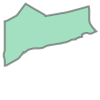

In [15]:
psa['geometry'][2]

In [16]:
shots_psa = gpd.sjoin(gdf, psa, how='left', op='within')

In [17]:
# Setting up the dataframe to have only the key features.  Keeping type, Date, PSA and index to keep it unique
shots_psa.reset_index(inplace=True)
shots_psa.drop(['geometry', 'Source', 'Time', 'index_right'], axis=1, inplace=True)
shots_psa.set_index('index', inplace=True)

In [18]:
# After a lot of review, the null values are not in Washington DC so we will drop them.
shots_psa.PSA.isnull().sum()

907

In [19]:
shots_psa.dropna(inplace=True)
shots_psa.PSA = shots_psa.PSA.astype(int)

# Only 48 of the 56 PSA are within the shots fired.  
print(shots_psa.PSA.nunique())
shots_psa.head()

48


,Type,Date,PSA
index,,,
5D39700,Multiple_Gunshots,2014-01-01,501
5D39701,Multiple_Gunshots,2014-01-01,502
5D39702,Multiple_Gunshots,2014-01-01,505
7D119445,Multiple_Gunshots,2014-01-01,708
1D55993,Multiple_Gunshots,2014-01-01,107


In [20]:
# shots_psa.to_csv('./assets/mpd/shots_train_psa.csv')

In [115]:
shots_psa = pd.read_csv('./assets/mpd/shots_train_psa.csv')

shots_psa.PSA = shots_psa.PSA.astype(str)
shots_psa = pd.get_dummies(shots_psa, columns=['Type'])
shots_psa.Date = pd.to_datetime(shots_psa.Date)
shots_psa.drop('index', axis=1, inplace=True)

shots_psa.head()

,Date,PSA,Type_Gunshot_or_Firecracker,Type_Multiple_Gunshots,Type_Single_Gunshot
0,2014-01-01,501,0,1,0
1,2014-01-01,502,0,1,0
2,2014-01-01,505,0,1,0
3,2014-01-01,708,0,1,0
4,2014-01-01,107,0,1,0


In [116]:
def mnth_yr(df):
    df = df.copy()
    df['mnth_yr'] = df.Date.dt.to_period('M')
    df.drop(['Date'], axis=1, inplace=True)
    return df

my_psa = mnth_yr(shots_psa)

In [117]:
my_psa = my_psa.groupby(['PSA', 'mnth_yr'])['Type_Multiple_Gunshots', 'Type_Single_Gunshot'].agg(['sum'])

In [118]:
my_psa.columns = my_psa.columns.droplevel(level=1)

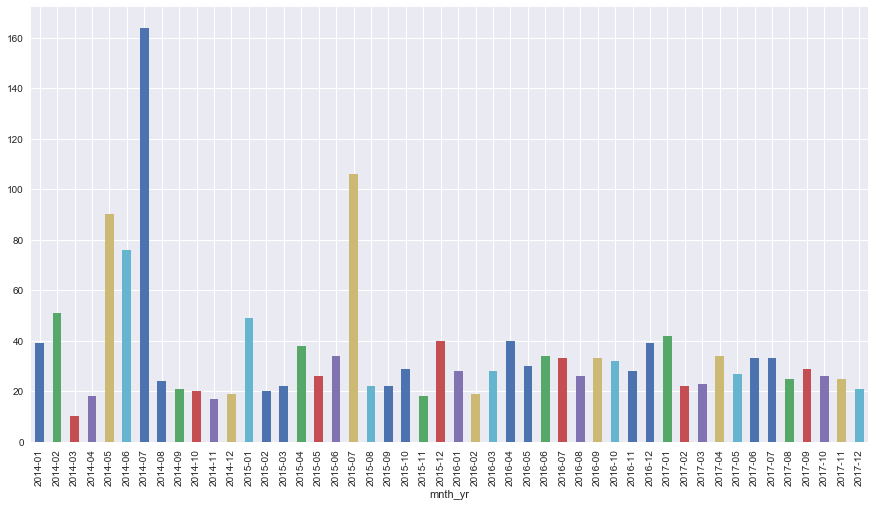

In [119]:
plt.figure(figsize=(15, 8))
foo = my_psa.reset_index()
for bar in foo['PSA'].unique():
    foo[foo['PSA'] == bar].set_index('mnth_yr')['Type_Multiple_Gunshots'].plot(kind='bar')

In [120]:
def date_separate(df):
    df = df.copy()
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
#     df['Day'] = pd.DatetimeIndex(df['Date']).day
    df.drop(['Date'], axis=1, inplace=True)
    return df

shots_psa = date_separate(shots_psa)

In [121]:
psa_month = shots_psa.groupby(['PSA', 'Month'])['Type_Multiple_Gunshots', 'Type_Single_Gunshot'].agg(['sum'])

psa_month.columns = psa_month.columns.droplevel(level=1)

In [122]:
psa_month.head()

Type_Multiple_Gunshots  Type_Single_Gunshot
PSA Month                                             
101 4                         1.0                  0.0
102 8                         1.0                  0.0
103 1                        15.0                  4.0
    2                         6.0                  2.0
    3                         8.0                  4.0

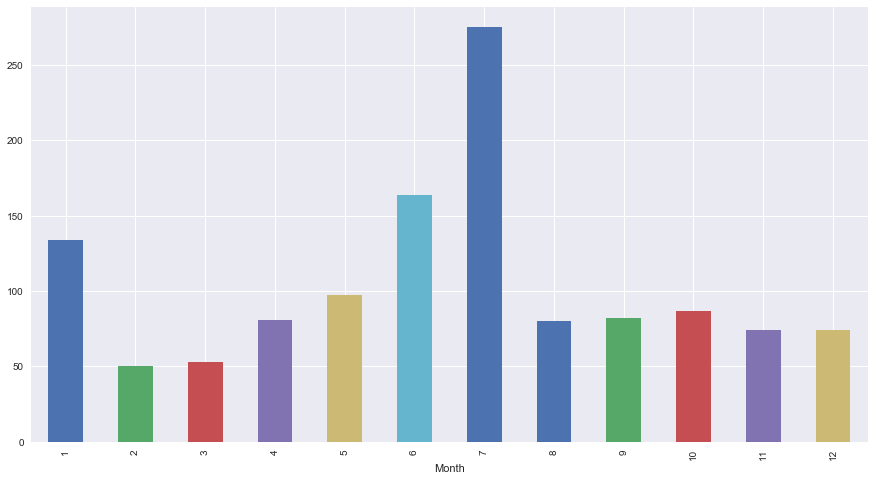

In [123]:
plt.figure(figsize=(15, 8))
foo = psa_month.reset_index()
for bar in foo['PSA'].unique():
    foo[foo['PSA'] == bar].set_index('Month')['Type_Multiple_Gunshots'].plot(kind='bar')

In [124]:
shots_psa.head()

,PSA,Type_Gunshot_or_Firecracker,Type_Multiple_Gunshots,Type_Single_Gunshot,Year,Month
0,501,0,1,0,2014,1
1,502,0,1,0,2014,1
2,505,0,1,0,2014,1
3,708,0,1,0,2014,1
4,107,0,1,0,2014,1


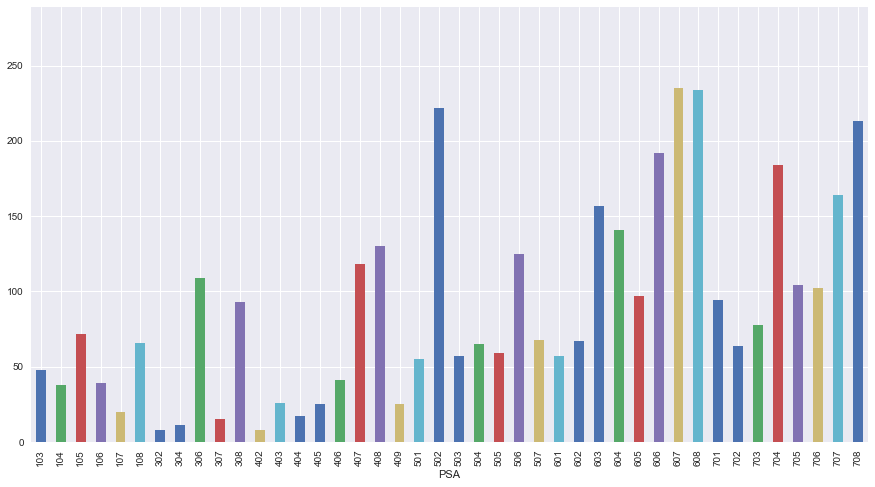

In [126]:
plt.figure(figsize=(15, 8))
foo = psa_month.reset_index()
for bar in foo['Month'].unique():
    foo[foo['Month'] == bar].set_index('PSA')['Type_Multiple_Gunshots'].plot(kind='bar')

In [164]:
shots_psa2014 = shots_psa[shots_psa.Year == 2014]
shots_psa2015 = shots_psa[shots_psa.Year == 2015]
shots_psa2016 = shots_psa[shots_psa.Year == 2016]
shots_psa2017 = shots_psa[shots_psa.Year == 2017]

In [165]:
def year_process(df):
    df = df.groupby(['Month'])['Type_Multiple_Gunshots', 'Type_Single_Gunshot'].agg(['sum'])
    df.columns = df.columns.droplevel(level=1)
    df = df.reset_index()
    return df

shots_psa2014 = year_process(shots_psa2014)
shots_psa2015 = year_process(shots_psa2015)
shots_psa2016 = year_process(shots_psa2016)
shots_psa2017 = year_process(shots_psa2017)

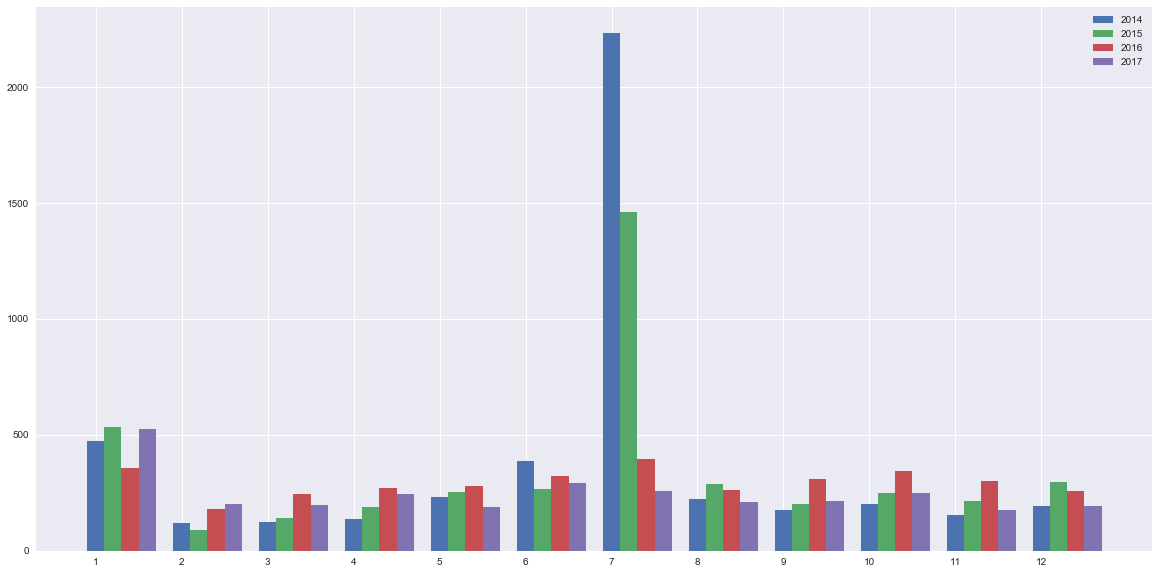

In [207]:
width = 0.2

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(shots_psa2014.Month+0.00, height=shots_psa2014.Type_Multiple_Gunshots, width=width, label='2014')
plt.bar(shots_psa2015.Month+0.2, height=shots_psa2015.Type_Multiple_Gunshots, width=width, label='2015')
plt.bar(shots_psa2016.Month+0.40, height=shots_psa2016.Type_Multiple_Gunshots, width=width, label='2016')
plt.bar(shots_psa2017.Month+0.6, height=shots_psa2017.Type_Multiple_Gunshots, width=width, label='2017')
plt.xticks(shots_psa2014.Month)
plt.legend();

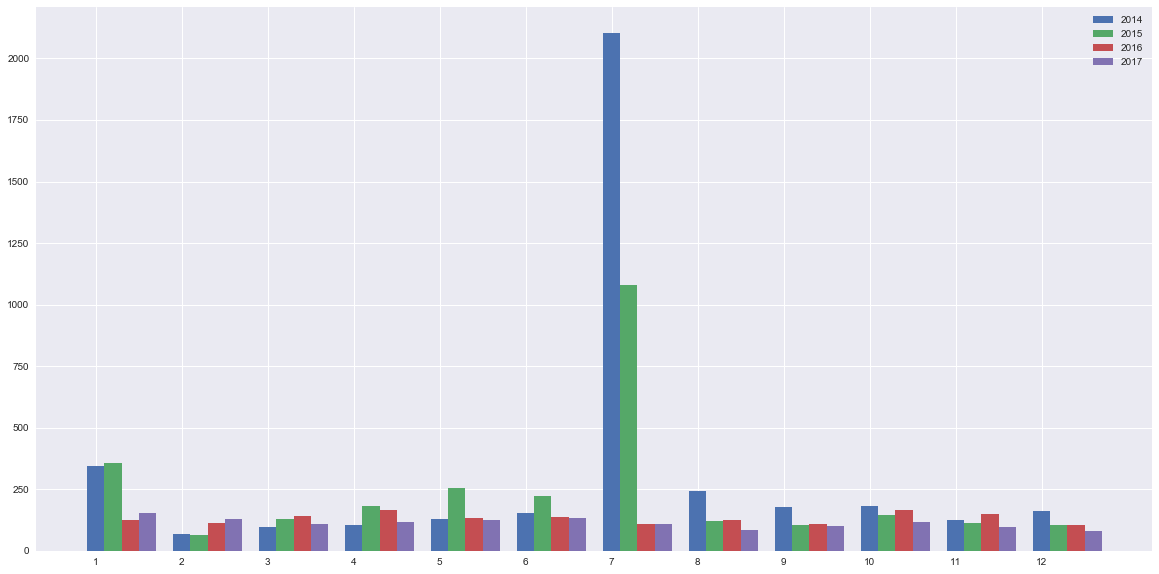

In [208]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(shots_psa2014.Month+0.00, height=shots_psa2014.Type_Single_Gunshot, width=width, label='2014')
plt.bar(shots_psa2015.Month+0.2, height=shots_psa2015.Type_Single_Gunshot, width=width, label='2015')
plt.bar(shots_psa2016.Month+0.40, height=shots_psa2016.Type_Single_Gunshot, width=width, label='2016')
plt.bar(shots_psa2017.Month+0.6, height=shots_psa2017.Type_Single_Gunshot, width=width, label='2017')
plt.xticks(shots_psa2014.Month)
plt.legend();

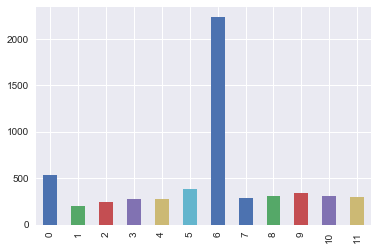

In [172]:
shots_psa2014.Type_Multiple_Gunshots.plot(kind='bar')
shots_psa2015.Type_Multiple_Gunshots.plot(kind='bar')
shots_psa2016.Type_Multiple_Gunshots.plot(kind='bar')
shots_psa2017.Type_Multiple_Gunshots.plot(kind='bar');

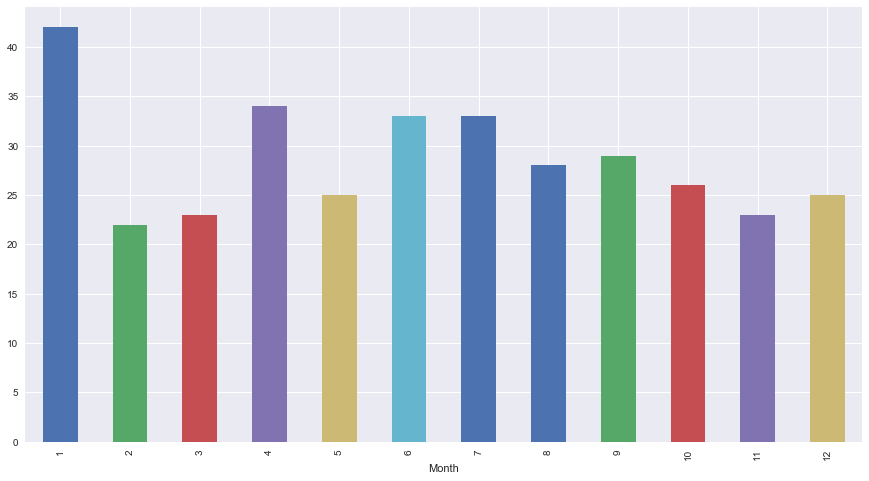

In [151]:
plt.figure(figsize=(15, 8))
# for bar in foo['PSA'].unique():
#     foo[foo['PSA'] == bar].set_index('Month')['Type_Multiple_Gunshots'].plot(kind='bar')

# for bar in foo1['PSA'].unique():
#     foo1[foo1['PSA'] == bar].set_index('Month')['Type_Multiple_Gunshots'].plot(kind='bar')

# for bar in foo2['PSA'].unique():
#     foo2[foo2['PSA'] == bar].set_index('Month')['Type_Multiple_Gunshots'].plot(kind='bar')

for bar in shots_psa2017['PSA'].unique():
    shots_psa2017[shots_psa2017['PSA'] == bar].set_index('Month')['Type_Multiple_Gunshots'].plot(kind='bar');

In [ ]:
homes = pd.read_csv('./assets/housing_data_psa.csv', index_col='Unnamed: 0')

In [33]:
look_up = {'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4', 'May': '5',
            'Jun': '6', 'Jul': '7', 'Aug': '8', 'Sep': '9', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

In [ ]:
list(sorted(zip(shots_psa.type_multiple_gunshots, shots_psa.index), reverse=True)[:10])

In [34]:
homes.month = homes.month.map(look_up)

In [35]:
homes.head()

,PSA,month,year,median_sale_price,homes_sold,homes_sold_mom,days_on_market,average_sale_to_list_mom
0,207,1,2014,499.0,58.0,-7.9,47,-0.3
1,207,2,2014,531.0,64.0,10.3,53,-0.9
2,207,3,2014,497.0,61.0,-4.7,49,-0.5
3,207,4,2014,499.0,66.0,8.2,42,0.1
4,207,5,2014,499.0,61.0,-7.6,32,0.6


In [36]:
homes = homes.groupby(['PSA', 'year', 'month']) \
    ['median_sale_price', 'homes_sold', 'homes_sold_mom', 
     'days_on_market', 'average_sale_to_list_mom'].agg('mean')

In [37]:
homes = homes.reset_index()

In [45]:
homes.PSA = homes.PSA.astype(str)

In [54]:
homes.shape, shots_psa.shape

((1248, 8), (1775, 5))

In [115]:
pd.merge(shots_psa, homes, how='left', left_on=('PSA', 'year'), right_on=('PSA', 'year')).isnull().sum()

PSA                            0
year                           0
month_x                        0
type_multiple_gunshots         0
type_single_gunshot            0
month_y                     1193
median_sale_price           1193
homes_sold                  1193
homes_sold_mom              1193
days_on_market              1193
average_sale_to_list_mom    1193
dtype: int64

In [63]:
# Merge Left so that we are only comparing the PSA
pd.merge(shots_psa, homes, how='inner', on=('PSA').head()

,PSA,year_x,month_x,type_multiple_gunshots,type_single_gunshot,year_y,month_y,median_sale_price,homes_sold,homes_sold_mom,days_on_market,average_sale_to_list_mom
0,102,2014,8,1,0,2014,1,461.0,70.0,-9.1,19.0,-0.3
1,102,2014,8,1,0,2014,10,458.0,100.0,14.9,18.0,0.0
2,102,2014,8,1,0,2014,11,474.0,94.0,-6.0,20.0,-0.2
3,102,2014,8,1,0,2014,12,484.0,96.0,2.1,21.0,-0.3
4,102,2014,8,1,0,2014,2,470.0,64.0,-8.6,25.0,0.3
